In [1]:
# Read in daily mean temperature for NYC Central Park for 2010 from text file
def read_text(file):
    f=open(file,'r')
    sat=f.read().splitlines()
    f.close()
    return sat

In [2]:
# Perform a least-squares fit to the observed NYC temperature data for 2010
import math

def lsq_fit(yobs):
    # we'll fit the data using a sinusoid model of the form f(x) = x0 + x1*cos(2*pi*((t-x2)/T)), with T = 365 days

    x0, x1, x2 = 55, 25, 200
    # prior parameter values

    # for each day of the year, compute the pre-fit model value and residual

    model_pre=[]
    res_pre=[]
    # initialize empty lists for returning
    
    for day in range(1,len(yobs)+1):
        model_pre.append(x0 + (x1*math.cos(2*math.pi*((day-x2)/365))))
        res_pre.append(model_pre[day-1]-int(yobs[day-1]))

    return model_pre, res_pre

In [3]:
# Print observed NYC temperature and pre-fit/post-fit model values to the screen
def print_data(obs, model_pre, res_pre):
    for day in range(0,len(obs)):
        if day == 0:
            print('day of year ',' obs temp (',chr(176),'F) ',' pre-fit model (',chr(176),'F) ',' pre-fit res (',chr(176),'F)',sep='')
            # add header row
        print('{0:11d}'.format(day+1),'{0:14d}'.format(int(obs[day])),'{0:19.1f}'.format(model_pre[day]),'{0:17.1f}'.format(res_pre[day]))
    return

In [4]:
# Plot observed and modeled NYC temperature time series
import matplotlib.pyplot as plt
import numpy as np

def plot_ts(yobs, model_pre, res_pre):

    # create an array of epochs
    epoch = np.array([x for x in range(1,len(yobs)+1)])

    # convert yobs from list of string objects to NumPy integer array
    temp=np.array([int(yobs[x]) for x in range(0,len(yobs))])

    # create a Figure object and two AxisSubplot objects within one column
    fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, dpi = 600)

    # add whitespace between subplots
    fig.tight_layout(pad = 2.0)

    # first subplot: observed temperature time series with pre-fit model overlaid
    ax0.plot(epoch, temp, c='black', label='observed')
    ax0.plot(epoch, model_pre, c='red', label='pre-fit model')

    # label the Y axis
    ax0.set_ylabel('$^\circ$F', fontweight='bold')

    # set the axes limits
    ax0.set_xlim(1, len(yobs))
    ax0.set_ylim(15, 100)

    # add a legend
    ax0.legend(loc = 'upper left')

    # title the plot
    ax0.set_title('NYC temperature: year 2010', fontweight = 'bold', fontstyle = 'italic')

    # second subplot: pre-fit residuals
    ax1.plot(epoch, res_pre, c='blue')

    # plot the zero line
    ax1.axhline(0.0, c = 'black', linestyle='dashed', linewidth = 2.5)

    # label the X and Y axes
    ax1.set_xlabel('day of year', fontweight='bold')
    ax1.set_ylabel('$^\circ$F', fontweight='bold', labelpad=1.0)

    # set the axes limits
    ax1.set_xlim(1, len(yobs))
    ax1.set_ylim(-25, 25)

    # title the plot
    ax1.set_title('Pre-fit residuals', fontweight = 'bold', fontstyle = 'italic')

    # save the plot to PDF file
    plt.savefig('Figure1.pdf')

    return

In [5]:
# Read ERA5 monthly SAT from NetCDF file
import numpy as np
import netCDF4 as nc

def read_netcdf(file):

    # open file with read only
    root = nc.Dataset(file, 'r')
    
    # read in latitudes and longitudes of the global grid
    lats = np.array(root['latitude'][:])
    lons = np.array(root['longitude'][:])

    # compute the distance between each grid point and NYC Central Park (40.8N, 286.0E)
    nyc_lat=40.8*(np.pi/180)
    nyc_lon=286.0*(np.pi/180)
    # lat/lon in radians

    r_Earth=6371
    # mean Earth radius in km

    dist_nyc = np.empty([len(lats),len(lons)])
    # initialize empty array of distances

    for i in range(0,len(lats)):
        for j in range(0,len(lons)):
            ilat=lats[i]*(np.pi/180)
            jlon=lons[j]*(np.pi/180)
            # lat/lon of current grid point in radians

            dist_nyc[i,j]=r_Earth*np.arccos(np.sin(nyc_lat)*np.sin(ilat)+np.cos(nyc_lat)*np.cos(ilat)*np.cos(nyc_lon-jlon))
            # distance between current grid point and NYC Central Park in km

    # find the lat/lon indices corresponding to the shortest distance
    indices=np.where(dist_nyc == np.min(dist_nyc))

    # read the SAT for the ERA5 grid point closest to NYC Central Park
    sat_nyc_era5 = np.array(root['SAT'][:, indices[0][0], indices[1][0]])

    # read the SAT for the global grid and compute the climatological annual mean
    sat_clim = (np.mean(np.array(root['SAT'][:, :, :]),axis=0)-273.15)*1.8+32
    # climatological annual mean SAT in degrees F

    return sat_nyc_era5, sat_clim, lats, lons

In [6]:
# Plot PDF (histogram) of NYC annual mean temperature based on ERA5 data
import matplotlib.pyplot as plt
import numpy as np

def plot_hist(sat_nyc_era5):

    # compute ERA5 annual mean temperature from monthly data
    sat_era5_annual = np.empty(int(len(sat_nyc_era5)/12))

    start=0
    finish=12
    # time indices for averaging

    for yr in range(0,int(len(sat_nyc_era5)/12)):

        sat_era5_annual[yr]=(np.mean(sat_nyc_era5[start:finish],axis=0)-273.15)*1.8+32
        # annual mean temperature in degrees F

        start += 12
        finish += 12

    # create histogram
    plt.figure(dpi = 600)
    plt.hist(sat_era5_annual, bins=12, range=(49.5,55.5), density=True)
    plt.xlabel('Temperature ($^\circ$F)')
    plt.ylabel('Probability Density ($^\circ$F$^{-1}$)')
    plt.title('NYC annual-mean temperature')

    # save the plot to PDF file
    plt.savefig('Figure2.pdf')

    return

In [23]:
# Produce global maps of ERA5 climatological annual mean temperature and first EOF of annual mean temperature
import numpy as np
import pygmt as gmt
import xarray as xr

def plot_maps(sat_clim, lats, lons):
    
    # appending to sat_clim at 360E longitude to avoid missing data on the plot near the prime meridian
    lons_append = np.empty(len(lons)+1)
    sat_clim_append = np.empty([181, 361])
    
    lons_append[0:360] = lons
    lons_append[360] = 360
    
    sat_clim_append[:,0:360] = sat_clim[:,0:360]
    sat_clim_append[:,360] = sat_clim[:,0]

    # create xarray grid
    sat_grid = xr.DataArray(sat_clim_append, coords = {'lat':lats, 'lon':lons_append} )

    # open a figure with PyGMT
    fig = gmt.Figure()

    # make some changes in the GMT parameters for esthetic purpose
    gmt.config(FONT_ANNOT = '9p', FONT_LABEL = '10p', FONT_TITLE = '14p', MAP_TITLE_OFFSET = '0p', MAP_TICK_LENGTH = '0p')

    # define colormap
    gmt.makecpt(cmap="batlow", series=[-65, 95, 5])

    # make a map using the Mollweide map projection
    fig.grdimage(grid = sat_grid, region = 'g', projection = 'W0/12c', frame = ['f', '+t"ERA5 climatological annual mean SAT"'], dpi = 600)

    # plot the coastlines
    fig.coast(shorelines = '1/0.5p,black', resolution = 'c')

    # add a color bar
    fig.colorbar(frame = ['x+l"SAT (@.F)"'])

    # save figure
    fig.savefig('Figure3.pdf')
    
    return

day of year  obs temp (°F)  pre-fit model (°F)  pre-fit res (°F)
          1             37                31.0              -6.0
          2             26                30.9               4.9
          3             20                30.8              10.8
          4             25                30.7               5.7
          5             25                30.6               5.6
          6             30                30.5               0.5
          7             34                30.4              -3.6
          8             28                30.3               2.3
          9             24                30.3               6.3
         10             21                30.2               9.2
         11             26                30.2               4.2
         12             30                30.1               0.1
         13             30                30.1               0.1
         14             36                30.0              -6.0
         15             4

grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.


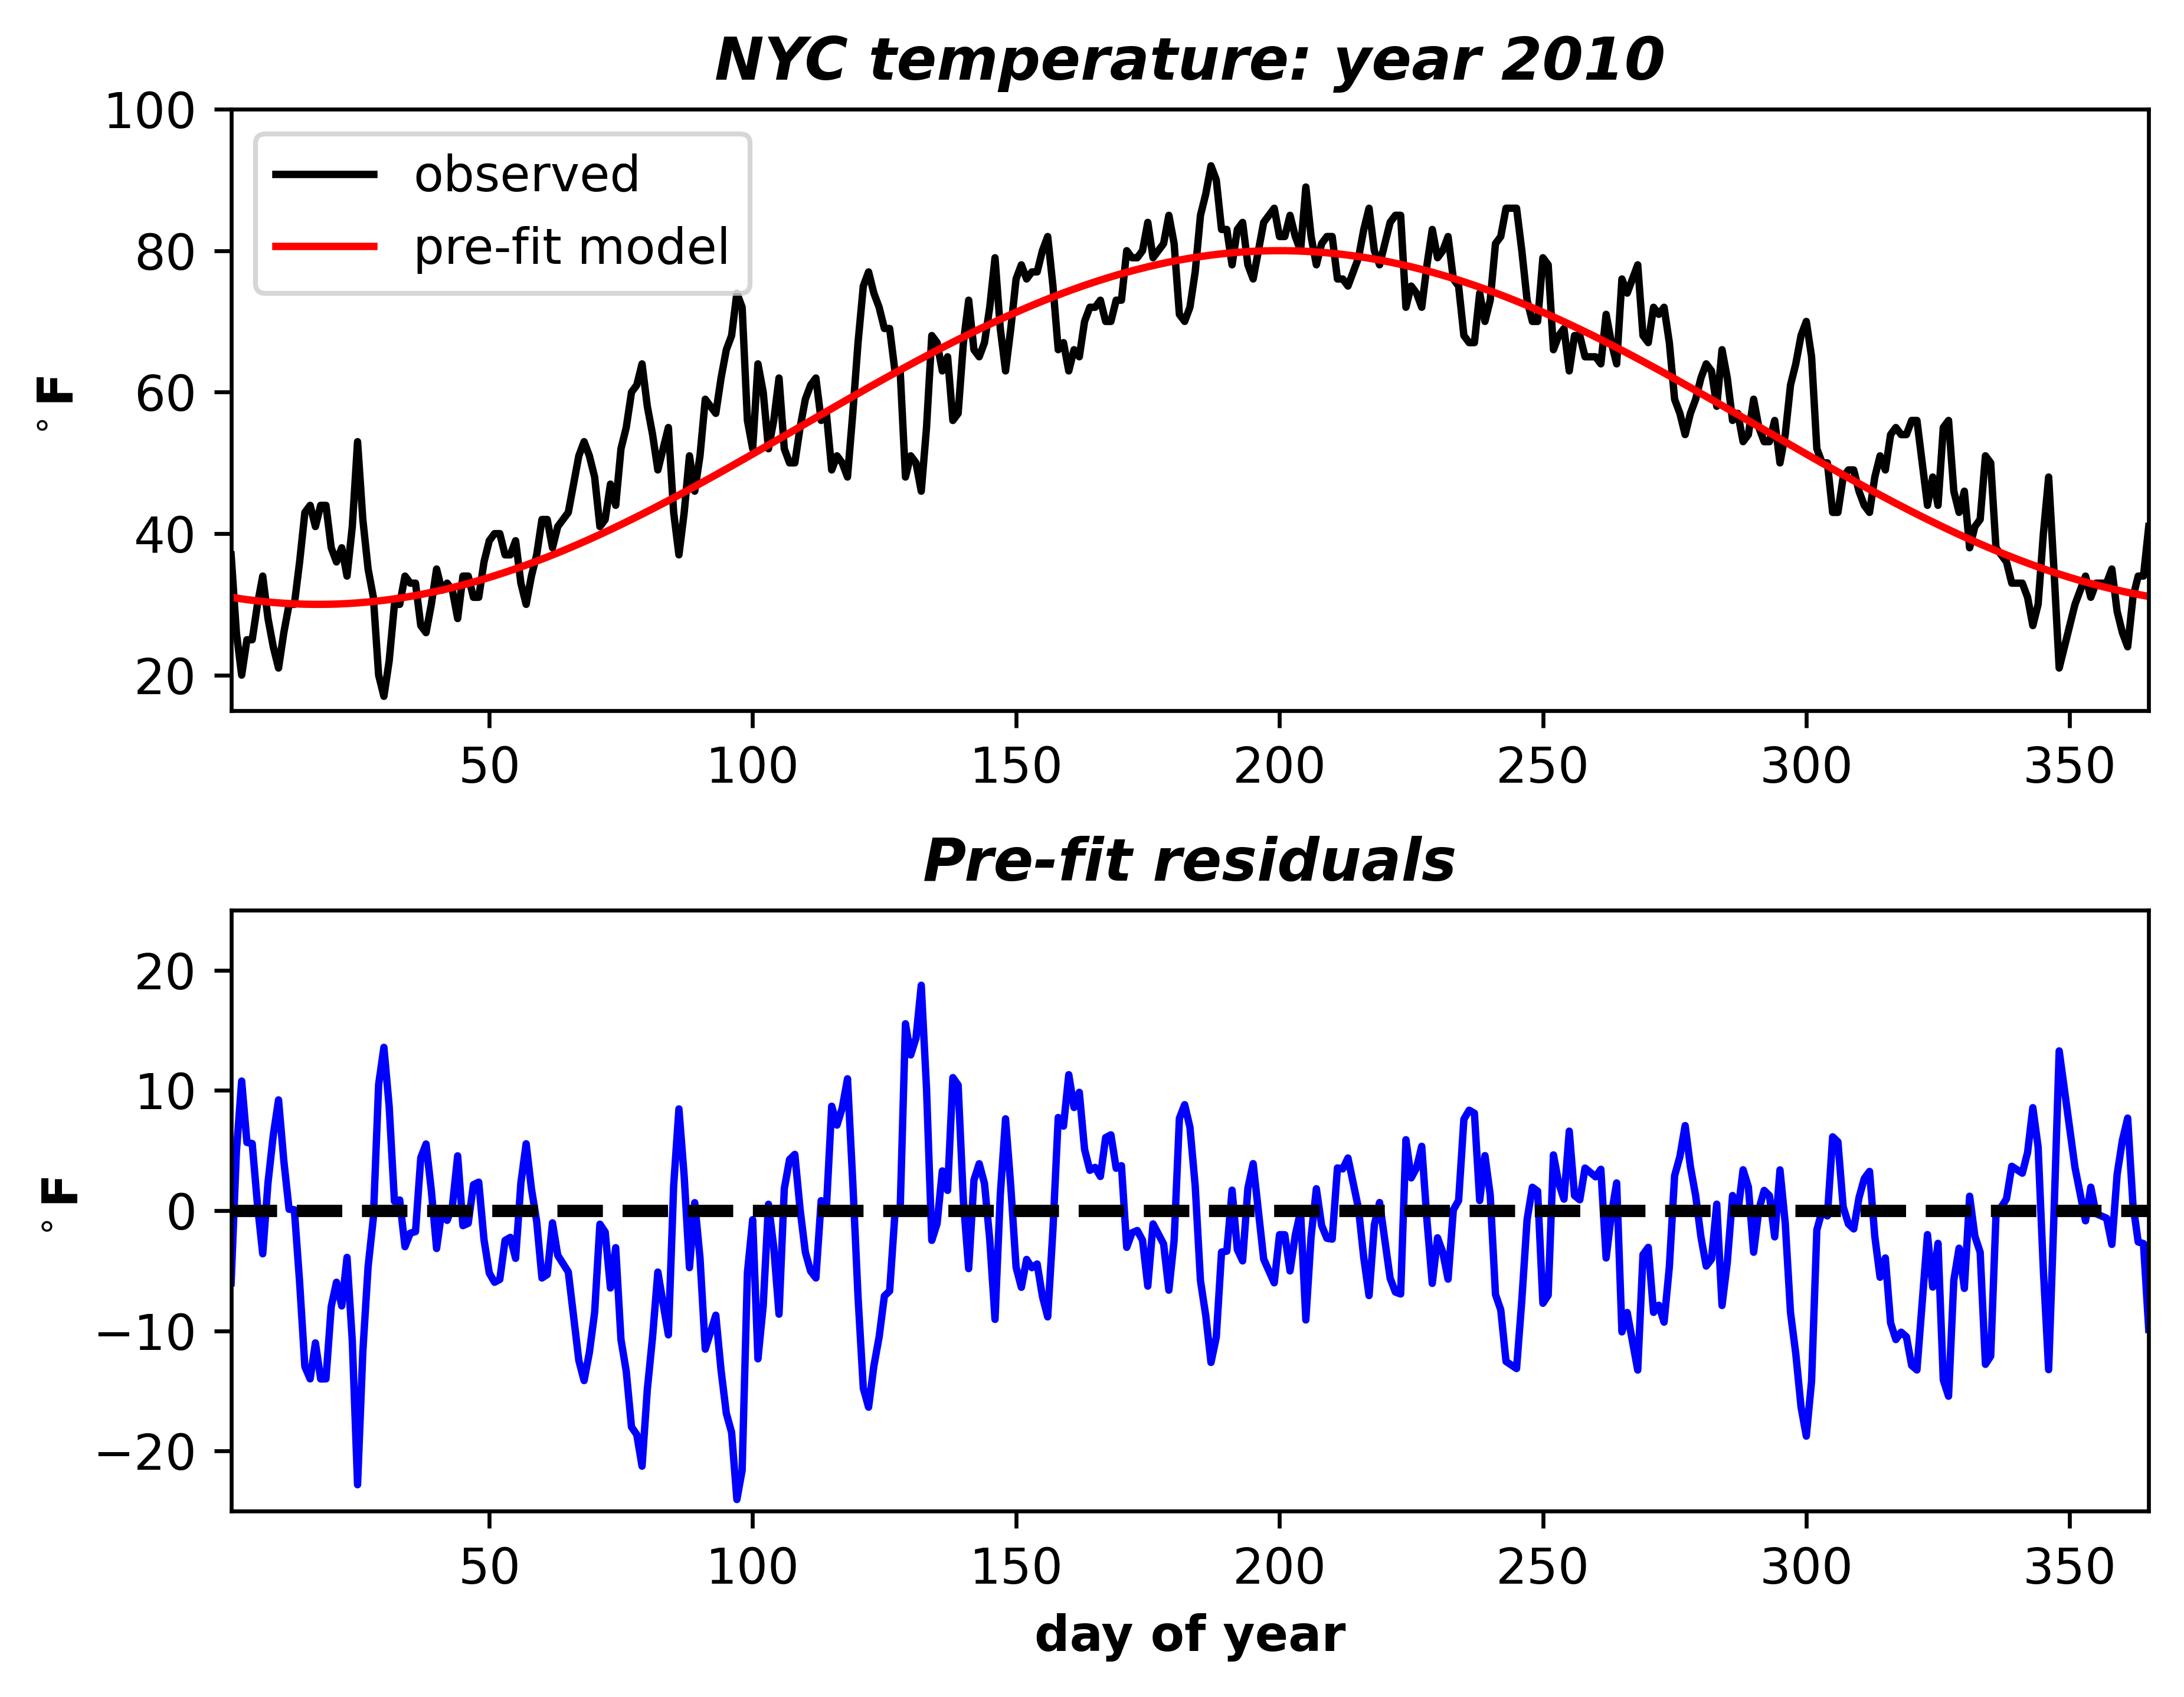

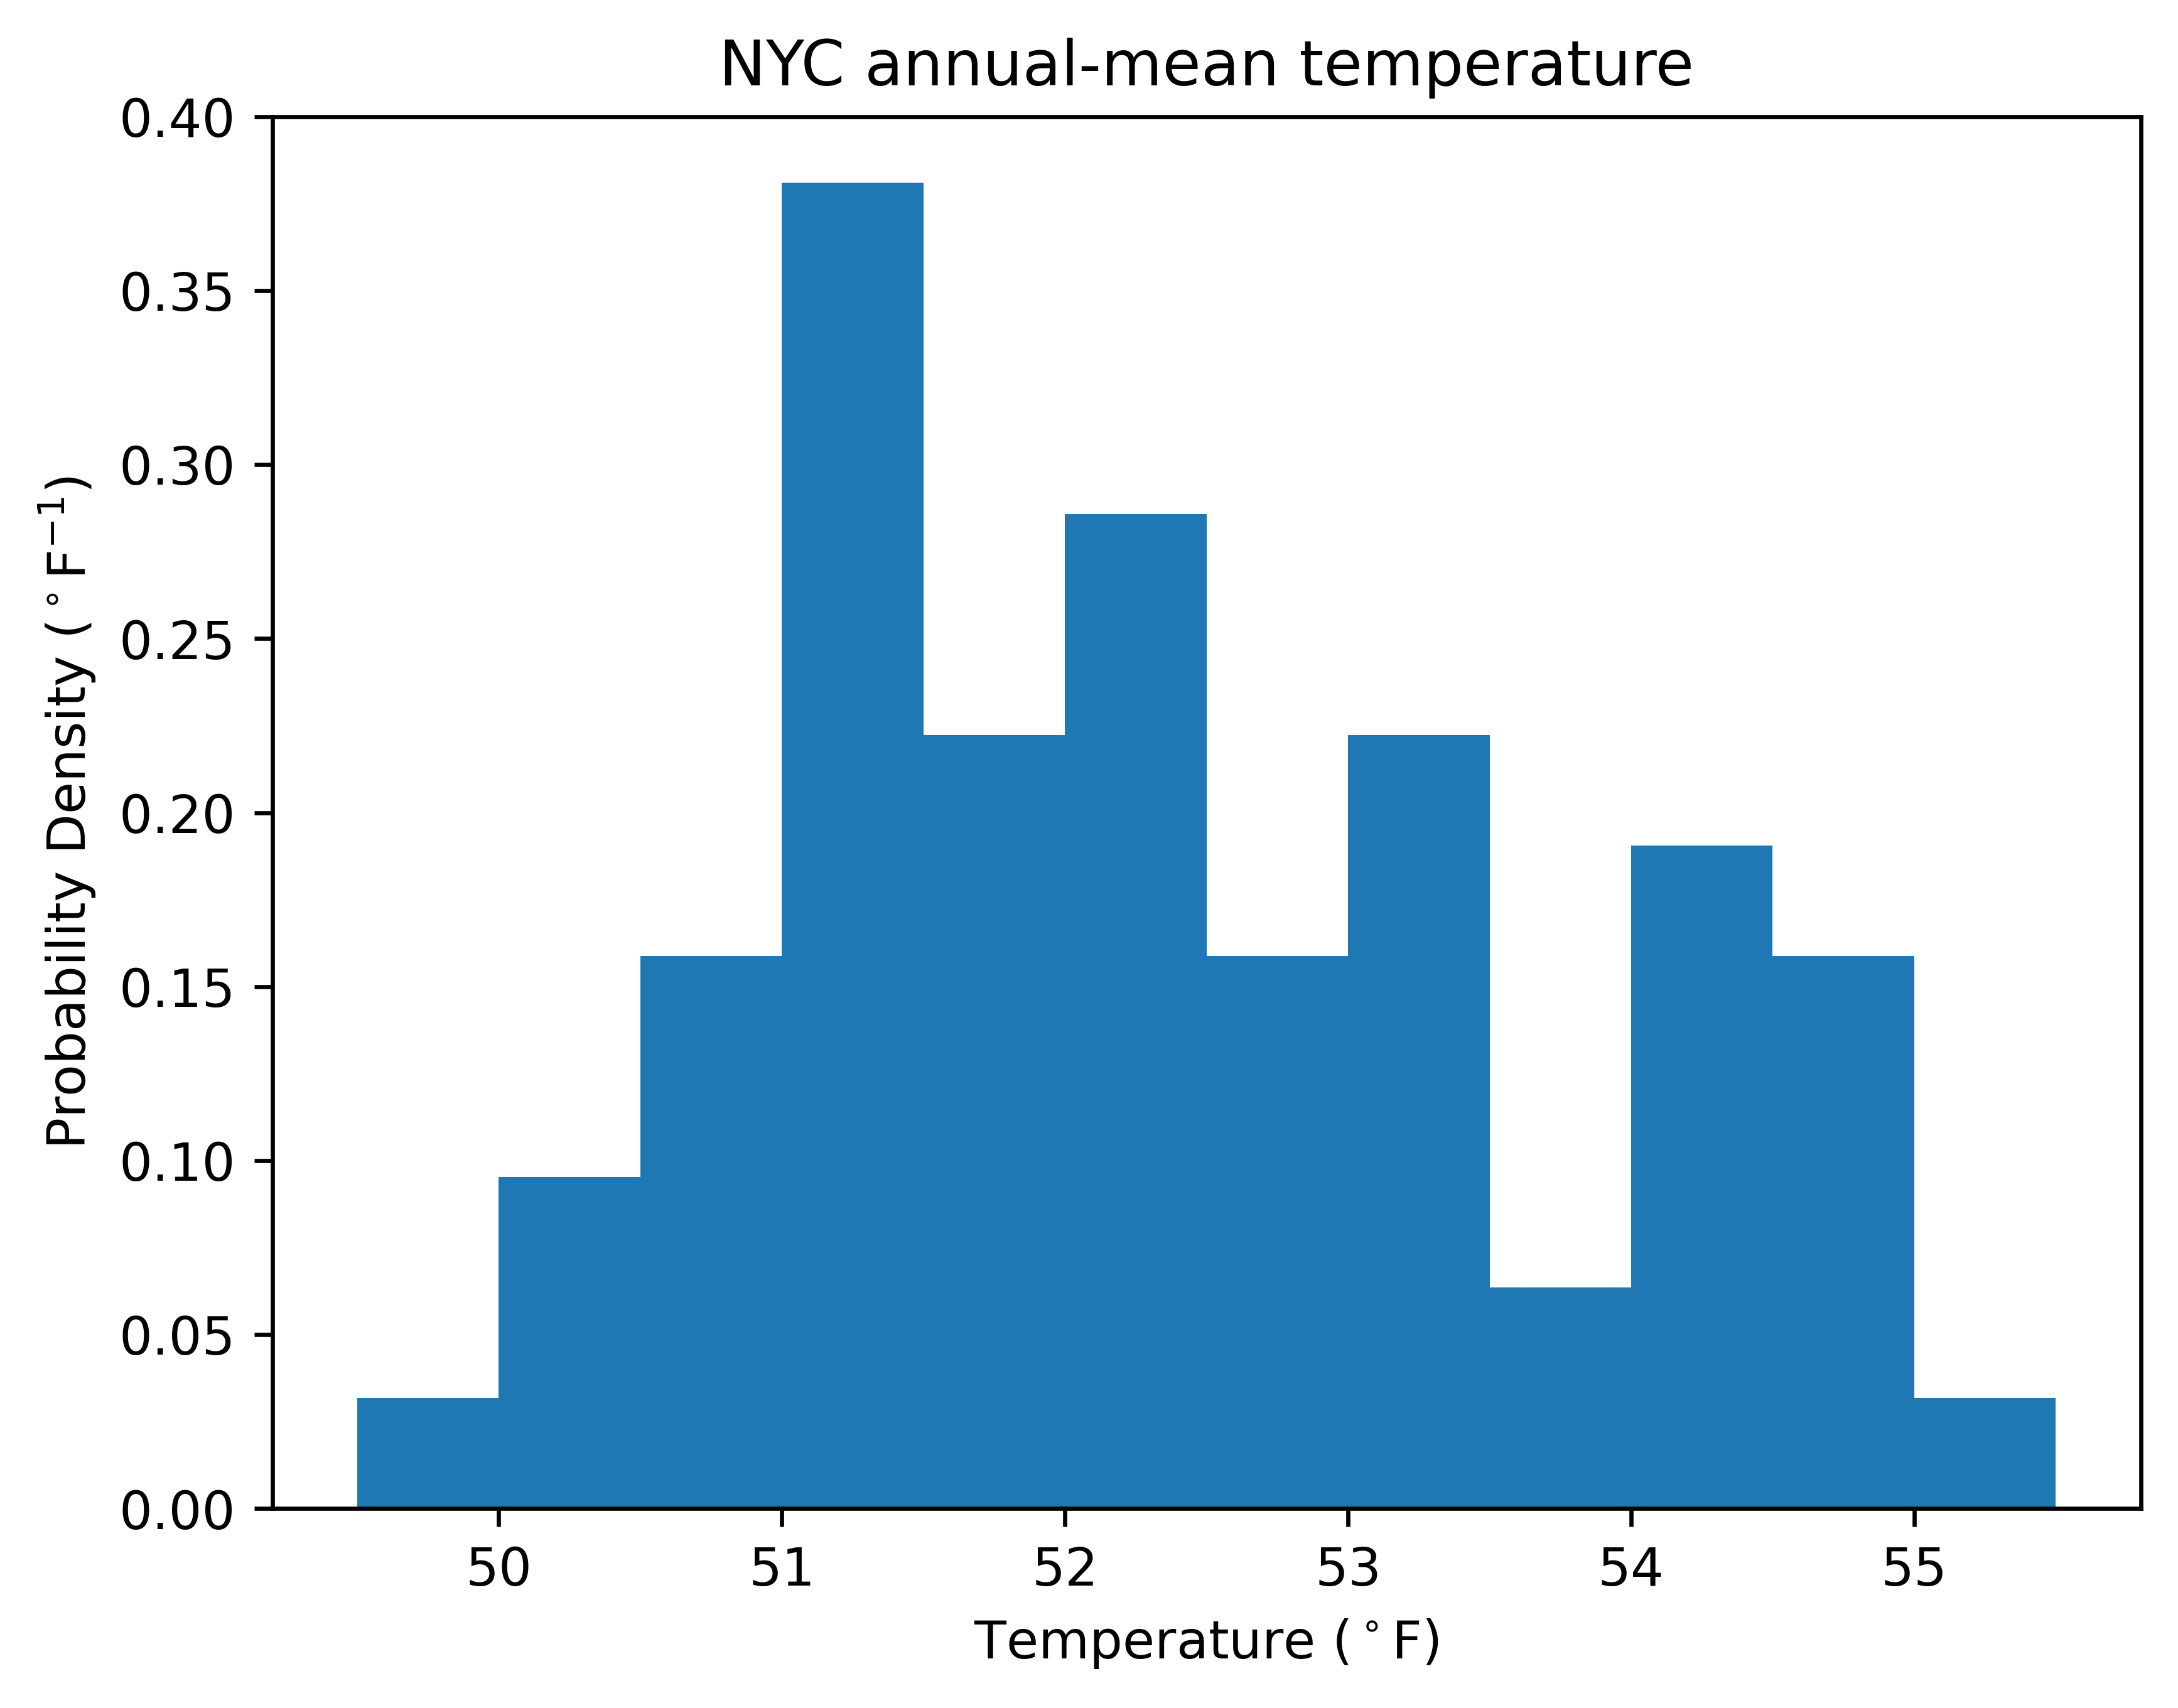

In [24]:
# Jupyter notebook group project for SUSC5060 - Spring 2024
# Written by M. Previdi

# Main routine

# Specify file names

file_text='nyc_temp_2010.txt'
# text file containing daily mean temperature for NYC Central Park for 2010

file_netcdf='ERA5_SAT_195901-202112.nc'
# NetCDF file containing global gridded monthly surface air temperature (SAT) for 1959-2021

# Function calls

sat_nyc_2010 = read_text(file_text)
# function is passed the text file name and returns the temperature data as a list

model_pre, res_pre = lsq_fit(sat_nyc_2010)
# function is passed the observed NYC temperature and returns the pre-fit model values and residuals (for now)

print_data(sat_nyc_2010, model_pre, res_pre)
# function is passed the observed NYC temperature and pre-fit model values/residuals (for now)

plot_ts(sat_nyc_2010, model_pre, res_pre)
# function to plot observed and modeled NYC temperature time series

sat_nyc_era5, sat_clim, lats, lons = read_netcdf(file_netcdf)
# function is passed the NetCDF file name and returns the ERA5 temperature time series for the grid point closest to NYC Central Park, as
# well as the global gridded climatological annual mean temperature and the associated lats/lons

plot_hist(sat_nyc_era5)
# function to plot PDF (histogram) of NYC annual mean temperature based on ERA5 data

plot_maps(sat_clim, lats, lons)
# function to produce global maps of ERA5 climatological annual mean temperature and first EOF of annual mean temperature

In [1]:
print('I added this as a test')

I added this as a test
